# To Do:  Make the plotting function work on databricks.

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, Pipeline
from pyspark.sql import functions as fn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

Create some data that follows the following equation and add some noise:

$$
f(x)=10+5x+0.5x^2-0.1x^3
$$

In [2]:
# create numpy arrays for x and y data
x = np.linspace(-15, 15, 250)
y = 10 + 5*x + 0.5*np.square(x) - 0.1*np.power(x,3)
reducible_error = np.random.uniform(-50, 50, len(x))
irreducible_error = np.random.normal(0, 8, len(x))
y_noise = y + reducible_error + irreducible_error

Text(0, 0.5, 'y, y_noise')

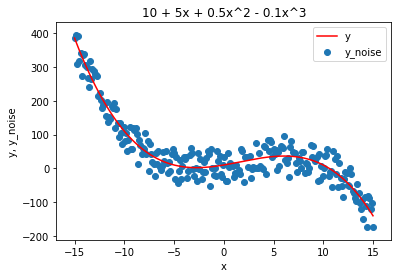

In [3]:
# plot x and y data
%matplotlib inline
plt.figure()
plt.plot(x,y, c='r', label="y")
plt.scatter(x, y_noise, label="y_noise")
plt.legend()
plt.title("10 + 5x + 0.5x^2 - 0.1x^3")
plt.xlabel("x")
plt.ylabel("y, y_noise")

Create pandas and spark dataframes from the cubic function data.

In [4]:
# create a pandas dataframe from the x, y, y_hat data arrays
pd_df = pd.DataFrame({'x': x, 'y_noise': y_noise, 'y_true': y})
pd_df.head()

,x,y_noise,y_true
0,-15.000000,384.298959,385.000000
1,-14.879518,394.128506,375.735055
2,-14.759036,309.240387,366.614220
3,-14.638554,390.143921,357.636445
4,-14.518072,318.602750,348.800681


In [5]:
# create a spark dataframe from the pandas dataframe
spark_df = spark.createDataFrame(pd_df)
spark_df.show()

+-------------------+------------------+------------------+
|                  x|           y_noise|            y_true|
+-------------------+------------------+------------------+
|              -15.0| 384.2989590507309|             385.0|
|-14.879518072289157|394.12850607216916| 375.7350551866342|
|-14.759036144578314|309.24038712565283| 366.6142199805173|
| -14.63855421686747| 390.1439208251551| 357.6364450398488|
|-14.518072289156626|318.60274961523294|348.80068102282837|
|-14.397590361445783| 339.4804458512408|340.10587858765587|
| -14.27710843373494| 274.2272547217922|331.55098839253077|
|-14.156626506024097|335.28272335819844| 323.1349610956528|
|-14.036144578313253|337.81639553744907| 314.8567473552215|
| -13.91566265060241| 306.6050529985905| 306.7152978294365|
|-13.795180722891565|298.75581301199475| 298.7095631764975|
|-13.674698795180722| 267.1519023247608| 290.8384940546042|
| -13.55421686746988| 239.6882138489437| 283.1010411219563|
|-13.433734939759036| 315.6890026026133|

Define some convenience functions to make the analysis easier.

In [6]:
# To Do:  Add model bias and variance calculations 

# define a function which performs a poplynomial expansion of features
# args
#   n: The polynomial expansion degree
#   df: A spark dataframe containing the data on which to perform polynomial expansion.  The 
#       input data is expected to be in a col named 'x'
#   lambda_reg: The regularization param lambda for L1 and L2 
#   alpha_reg: The elastic net regularization param alpha.  alpha = 0 means 100% L2 regularization.
# Return Vals:  Returns a fitted data frame in pandas format, and the fitted spark pipeline
def plot_poly_expansion(n, df, lambda_reg=0., alpha_reg=0.):
    # create the pipeline
    va = feature.VectorAssembler(inputCols=['x'], outputCol='features')
    pe = feature.PolynomialExpansion(degree=n, inputCol='features', outputCol='poly_features')
    lr = regression.LinearRegression(featuresCol='poly_features', labelCol='y_noise', regParam=lambda_reg, 
                                     elasticNetParam=alpha_reg)
    pipe = Pipeline(stages=[va, pe, lr]).fit(df)
    
    # fit the pipeline
    fit_df = pipe.transform(df)

    # convert the fitted spark dataframe to pandas and plot predicted vs. actual
    fit_pd_df = fit_df.toPandas()
    
    # display(fit_pd_df.head())
    plt.figure()
    plt.plot(fit_pd_df['x'], fit_pd_df['y_true'], label='y_true', c='red')
    plt.scatter(fit_pd_df['x'], fit_pd_df['y_noise'], label='y_noise')
    plt.scatter(fit_pd_df['x'], fit_pd_df['prediction'], label='prediction')
    #fit_pd_df.plot(x='x', y=['y_true', 'y_noise', 'prediction'])
    plt.title("Polynomial degree = %s, lambda = %s, alpha = %s" % (n, lambda_reg, alpha_reg))
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    
    return fit_pd_df, pipe

Perform a fit for n=2 and check the head of the returned data.  Note how the polynomial expansion performed feature engineering and created new data columns 'poly_features' which is a combination of the 'x' column and a polynomial expansion of 2. 

,x,y_noise,y_true,features,poly_features,prediction
0,-15.000000,384.298959,385.000000,[-15.0],"[-15.0, 225.0]",251.001556
1,-14.879518,394.128506,375.735055,[-14.879518072289157],"[-14.879518072289157, 221.40005806357962]",248.163260
2,-14.759036,309.240387,366.614220,[-14.759036144578314],"[-14.759036144578314, 217.8291479169691]",245.339527
3,-14.638554,390.143921,357.636445,[-14.63855421686747],"[-14.63855421686747, 214.2872695601684]",242.530358
4,-14.518072,318.602750,348.800681,[-14.518072289156626],"[-14.518072289156626, 210.77442299317752]",239.735751


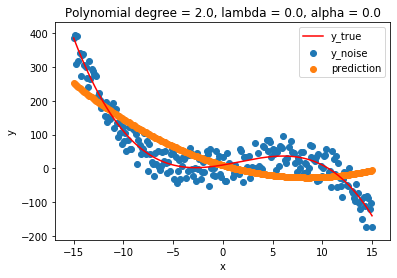

In [7]:
fit2, _ = plot_poly_expansion(2., spark_df)
display(fit2.head())

The following cell plots the fits for polynomial expansion for n = 1 to 3.

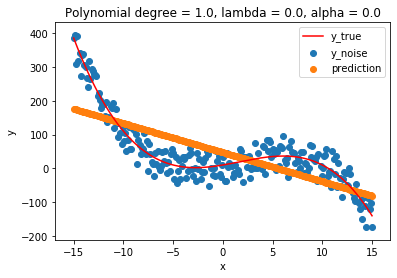

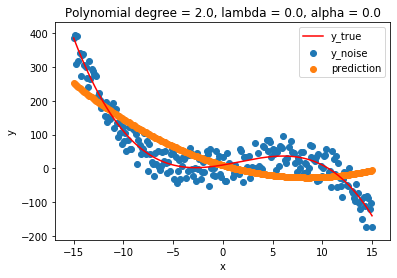

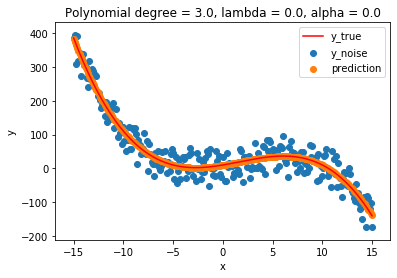

In [8]:
for i in np.arange(1, 4):
    plot_poly_expansion(float(i), spark_df)

The next cell uses L2 regularization to avoid overfitting.  Note how the prediction no longer exactly follows y_true.

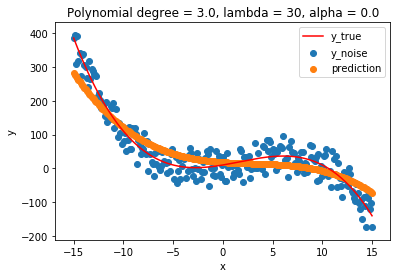

In [9]:
# try some regularization on the heavily overfit case of poly expansion = 3
fit, pipe = plot_poly_expansion(3., spark_df, lambda_reg=30)

The following cell shows how a range of regularization parameters affects the fit.  Bigger regularization values leads to more model bias and less variance.

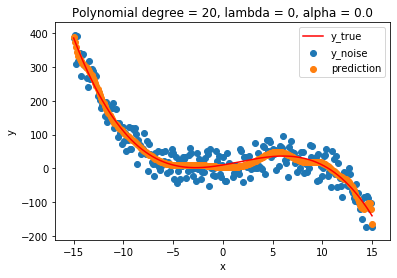

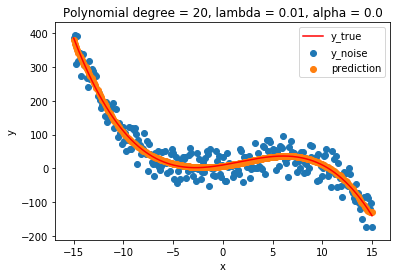

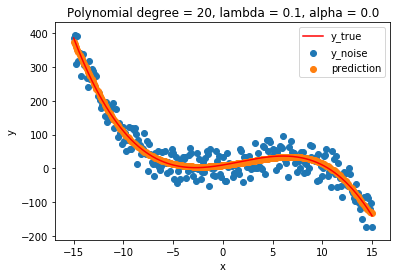

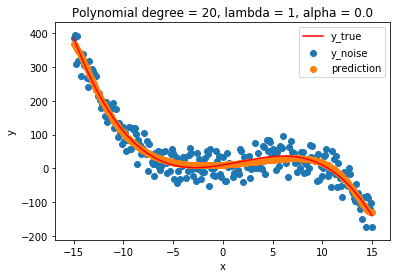

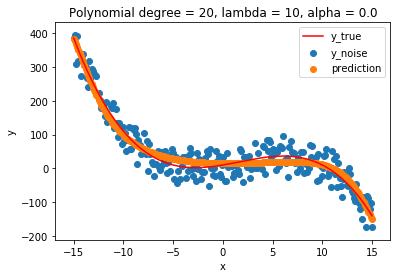

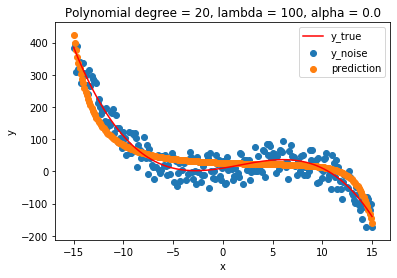

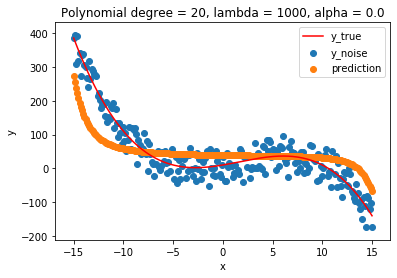

In [10]:
# define a list of regularization params list and number of polynomial expansion params
reg_params = [0, 0.01, 0.1, 1, 10, 100, 1000]
num_params = 20

# define a list to store coefficients 
coef_list = []

# for each regularization param
for reg in reg_params:
    # fit and plot the model
    fit, pipe = plot_poly_expansion(num_params, spark_df, reg)
    
    # append the model coefficients to the list
    coef_list.append(pipe.stages[-1].coefficients.toArray())

The plot below shows how the regression coefficients shrink towards 0 as the L2 regularization parameter lambda is increased.  The large Y scale shows how coefficients that start out far away from 0 shrink towards 0. The small Y scall shows that there are coefficients that start out close to 0 and also shrink towards 0. 

(7, 20)


Text(0, 0.5, 'Coefficient')

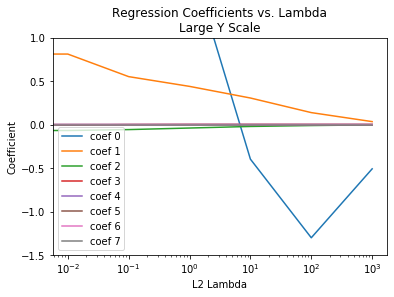

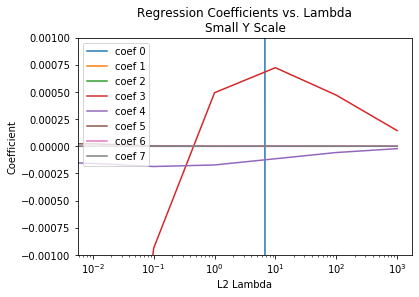

In [11]:
coef_array = np.array(coef_list)
print(coef_array.shape)
plt.figure()
for i in np.arange(8):
    plt.semilogx(reg_params, coef_array[:,i], label="coef %s" % i)
plt.ylim(-1.5, 1)
plt.legend()
plt.title("Regression Coefficients vs. Lambda\nLarge Y Scale")
plt.xlabel("L2 Lambda")
plt.ylabel("Coefficient")

plt.figure()
for i in np.arange(8):
    plt.semilogx(reg_params, coef_array[:,i], label="coef %s" % i)
#plt.ylim(-1.5, 1)
plt.ylim(-.001, .001)
plt.legend()
plt.title("Regression Coefficients vs. Lambda\nSmall Y Scale")
plt.xlabel("L2 Lambda")
plt.ylabel("Coefficient")